In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy.orm import Session
import scikit_posthocs as sp

from april.database import get_engine
from april.fs import PLOT_DIR
from april.utils import microsoft_colors, prettify_dataframe, cd_plot, get_cd
from april.enums import Base, Strategy, Heuristic

sns.set_style('white')
pd.set_option('display.max_rows', 50)
%config InlineBackend.figure_format = 'retina'

In [2]:
out_dir = PLOT_DIR / 'isj-2019'
eval_file = out_dir / 'eval.pkl'

### Helper objects

In [3]:
synth_datasets = ['paper', 'p2p', 'small', 'medium', 'large', 'huge', 'gigantic', 'wide']
bpic_datasets = ['bpic12', 'bpic13', 'bpic15', 'bpic17']
anonymous_datasets = ['real']
datasets = synth_datasets + bpic_datasets + anonymous_datasets
dataset_types = ['Synthetic', 'Real-life']

binet_ads = ["BINetv1", "BINetv2", "BINetv3"]
nn_ads = ["DAE"] + binet_ads
h_ads = nn_ads + [ "Likelihood+", "t-STIDE+", "Naive+"]
d_ads = ["Naive", "Sampling", "Likelihood", "OC-SVM"]
ads = h_ads + d_ads

heuristics = [r'$best$', r'$default$', r'$elbow_\downarrow$', r'$elbow_\uparrow$', 
              r'$lp_\leftarrow$', r'$lp_\leftrightarrow$', r'$lp_\rightarrow$']

## Retrieve evaluations from pickle file

In [4]:
evaluation = pd.read_pickle(eval_file)

### Add identifier for BPIC datasets and filter for ADs

In [5]:
evaluation = evaluation.query(f'ad in {ads} and label == "Anomaly"')

In [6]:
evaluation['perspective-label'] = evaluation['perspective'] + '-' + evaluation['label']
evaluation['attribute_name-label'] = evaluation['attribute_name'] + '-' + evaluation['label']
evaluation['dataset_type'] = 'Synthetic'
evaluation.loc[evaluation['process_model'].str.contains('bpic'), 'dataset_type'] = 'Real-life'
evaluation.loc[evaluation['process_model'].str.contains('real'), 'dataset_type'] = 'Real-life'

### Filter for best strategy

In `5.1 Best Strategy.ipynb` we find that $\tau_0$ and $\tau_a$ seem to work best overall. Intuatively it makes sense to set a threshold $\tau$ per attribute, hence we select $\tau_a$ whereever applicable.

In [7]:
_filtered_evaluation = evaluation.query(f'ad in {h_ads} and (strategy == "{Strategy.ATTRIBUTE}"'
                                       f' or (strategy == "{Strategy.SINGLE}" and process_model == "bpic12")'
                                       f' or (strategy == "{Strategy.SINGLE}" and ad == "Naive+")) or ad in {d_ads}')

### Filter for best heuristic

In `5.2 Best Heuristic.ipynb` we find that $lp_\rightarrow$ works best overall, aparat from DAE. For DAE we use $elbow_\uparrow$. For all default methods we use $default$.

In [8]:
filtered_evaluation = _filtered_evaluation.query(f'heuristic == "{Heuristic.DEFAULT}"'
                                                 f' or (heuristic == "{Heuristic.LP_MEAN}" and ad != "DAE")'
                                                 f' or (heuristic == "{Heuristic.ELBOW_UP}" and ad == "DAE")')

## Plot featured in paper (Figure 10)

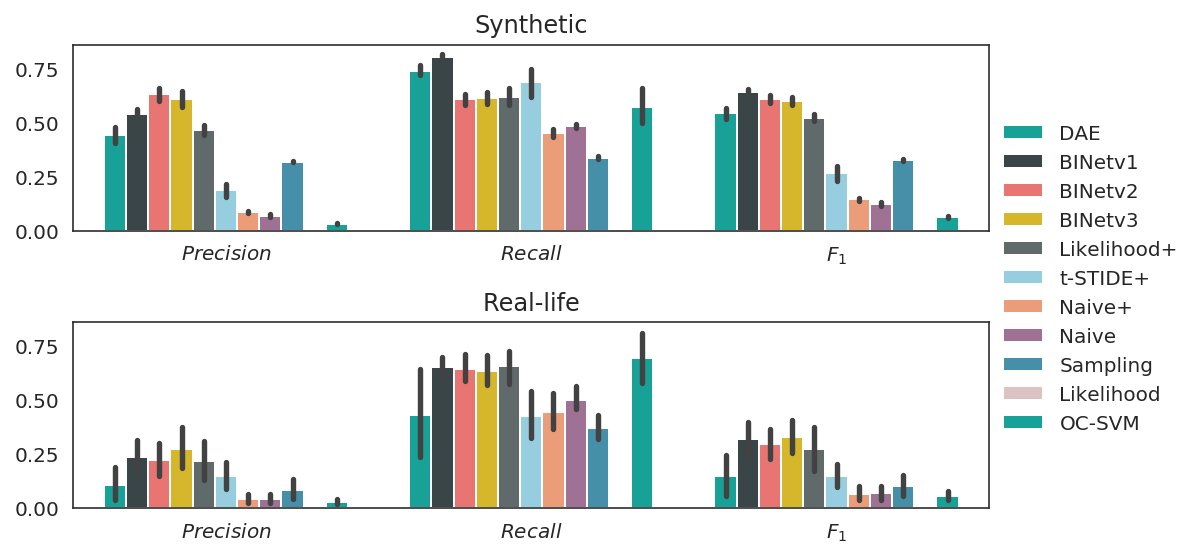

In [19]:
# Set up dataframe
df = filtered_evaluation.query('axis == 2')  # We give results on attribute level
df = prettify_dataframe(df)

# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad'], columns=['dataset_type', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()

# Plot
df = df.melt(id_vars=['ad', 'dataset_type', 'dataset_name'], value_vars=['precision', 'recall', 'f1'], var_name='metric')
df = df.replace('f1', r'$F_1$').replace('precision', r'$Precision$').replace('recall', r'$Recall$')

g = sns.FacetGrid(data=df, row='dataset_type', sharex=False, sharey=True, despine=False, height=2, aspect=3.5, row_order=dataset_types)
g = g.map_dataframe(sns.barplot, x='metric', y='value', hue='ad', palette=microsoft_colors, hue_order=ads, order=[r'$Precision$', r'$Recall$', r'$F_1$'])
g = g.add_legend()

g.axes.flat[0].set(title='Synthetic')
g.axes.flat[1].set(title='Real-life')

g.savefig(str(out_dir / 'eval_overall.pdf'))

## Significance Test (Fig. 11)

Pairwise significance shown in CD diagram (Demsar 2006).

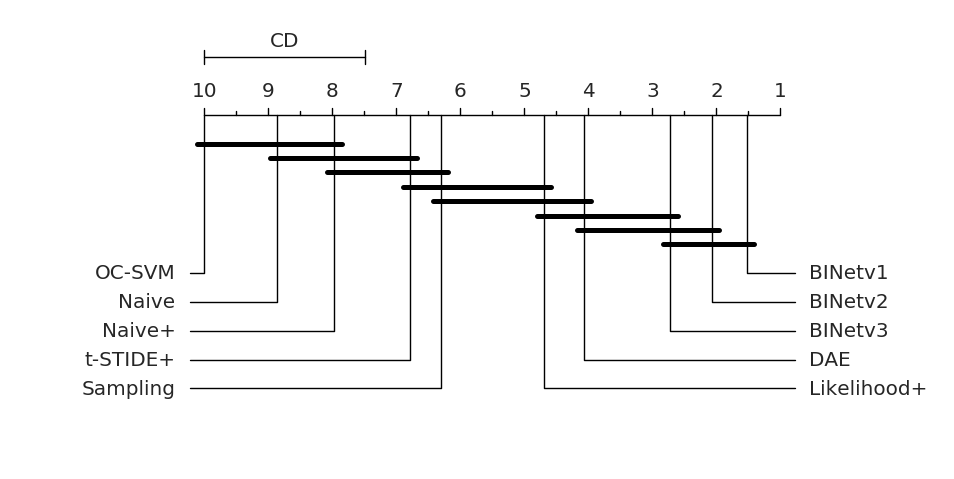

In [14]:
df = filtered_evaluation.query('axis == 2 and dataset_type == "Synthetic"')
df = prettify_dataframe(df)

# We first have to average for the two perspectives (to always weigh CF and Data 1 to 1), then we can average over all runs and datasets
df = df.groupby(['ad', 'file_name', 'dataset_type', 'dataset_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['ad', 'dataset_type', 'dataset_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])  # We recalculate the F1 score based on the new averaged P and R values
# df['f1'] = df['f1'].fillna(0)

# We want to penalize DAE for running out of memory on some of the BPIC datasets, hence we set the F1 score to zero where DAE has NaN values
df = pd.pivot_table(df, index=['ad', 'dataset_type'], columns=['dataset_name'], values=['f1'])
df = df.fillna(0)
df = df.stack(1).reset_index()

# Rank by F1 score
df['rank'] = df.groupby(['dataset_name'])['f1'].rank(ascending=False)

k = len(df['ad'].unique())
n = len(df) / k
alpha = 0.05
cd = get_cd(k, n, alpha)  # Critical difference for k groups, n blocks

ranks = df.groupby(['ad'])['rank'].agg(np.mean).dropna().round(2)
fig = cd_plot(ranks, cd=cd, reverse=True)
fig.savefig(str(out_dir / 'significance.pdf'))

Pairwise significance using Nemenyi-Friedman.

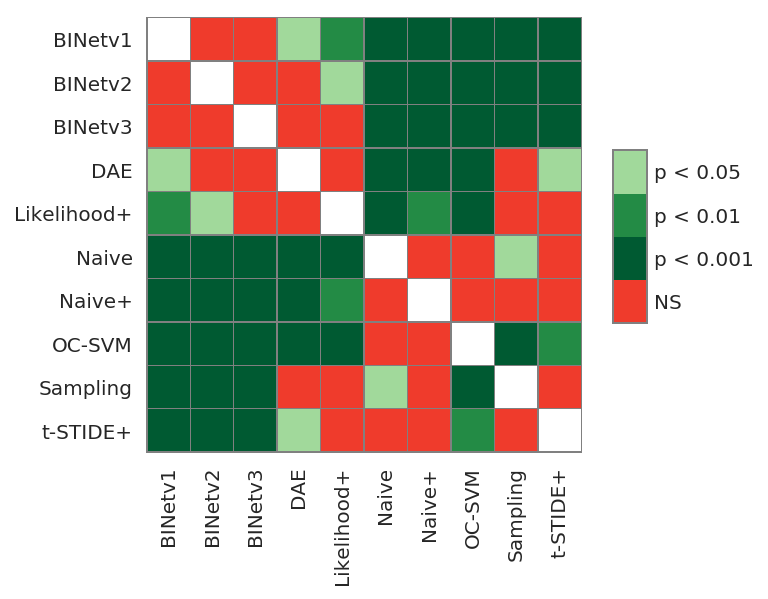

In [11]:
nemenyi_df = df.groupby(['ad', 'dataset_name'])['rank'].mean().dropna().reset_index()
pc = sp.posthoc_nemenyi_friedman(nemenyi_df, y_col='rank', group_col='ad', block_col='dataset_name', melted=True)
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

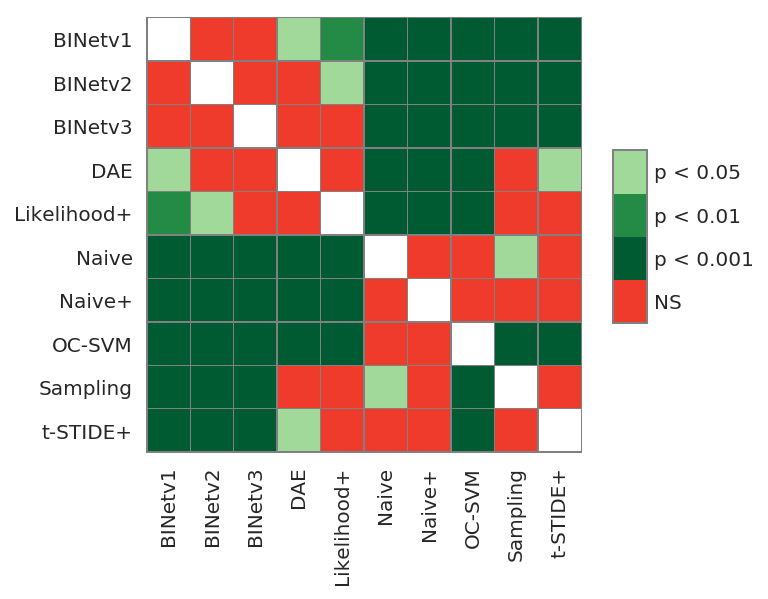

In [12]:
dunn_df = df.groupby(['ad', 'dataset_name'])['rank'].mean().dropna().reset_index()
pc = sp.posthoc_dunn(dunn_df, val_col='rank', group_col='ad', p_adjust='bonferroni')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
fig = sp.sign_plot(pc, **heatmap_args)

## Result table featured in the paper (Table 2)

In [15]:
df = filtered_evaluation.query('axis in [0, 2]')
df = prettify_dataframe(df)
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name', 'perspective'])['precision', 'recall', 'f1'].mean().reset_index()
df = df.groupby(['axis', 'process_model', 'dataset_name', 'ad', 'file_name'])['precision', 'recall', 'f1'].mean().reset_index()
df['f1'] = 2 * df['recall'] * df['precision'] / (df['recall'] + df['precision'])

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model', 'dataset_name'], values=['precision', 'recall', 'f1'])
df = df.fillna(0)
df = df.stack(1).stack(1).reset_index()
df.to_excel(str(out_dir / 'table.xlsx'), index=False)

df = pd.pivot_table(df, index=['axis', 'ad'], columns=['process_model'], values=['f1'], aggfunc=np.mean)
df.round(2)

f1                                                   \
process_model         BPIC12 BPIC13 BPIC15 BPIC17 Gigantic  Huge Large Medium   
axis      ad                                                                    
Attribute BINetv1       0.42   0.27   0.17   0.35     0.61  0.62  0.61   0.64   
          BINetv2       0.34   0.25   0.19   0.29     0.56  0.60  0.59   0.60   
          BINetv3       0.48   0.29   0.19   0.35     0.54  0.59  0.57   0.59   
          DAE           0.06   0.09   0.00   0.24     0.46  0.55  0.56   0.56   
          Likelihood    0.00   0.00   0.00   0.00     0.00  0.00  0.00   0.00   
          Likelihood+   0.34   0.29   0.07   0.24     0.51  0.54  0.49   0.54   
          Naive         0.05   0.05   0.01   0.10     0.09  0.11  0.09   0.12   
          Naive+        0.05   0.05   0.01   0.09     0.13  0.13  0.13   0.16   
          OC-SVM        0.05   0.06   0.01   0.09     0.07  0.05  0.04   0.08   
          Sampling      0.08   0.07   0.01   0.14     0.31  0.34  0.34   0.32   
          t-STIDE+      0.40   0.12   0.05   0.17     0.19  0.26  0.25   0.25   
Case      BINetv1       0.62   0.40   0.35   0.47     0.71  0.71  0.71   0.73   
          BINetv2       0.61   0.40   0.38   0.43     0.68  0.70  0.71   0.72   
          BINetv3       0.66   0.45   0.36   0.49     0.66  0.69  0.69   0.71   
          DAE           0.60   0.21   0.00   0.30     0.63  0.70  0.71   0.71   
          Likelihood    0.00   0.00   0.00   0.00     0.00  0.00  0.00   0.00   
          Likelihood+   0.62   0.45   0.33   0.40     0.67  0.68  0.62   0.65   
          Naive         0.55   0.21   0.17   0.31     0.34  0.40  0.41   0.39   
          Naive+        0.55   0.21   0.17   0.28     0.38  0.45  0.49   0.44   
          OC-SVM        0.55   0.24   0.26   0.35     0.29  0.23  0.24   0.29   
          Sampling      0.55   0.21   0.17   0.32     0.45  0.49  0.49   0.47   
          t-STIDE+      0.68   0.32   0.29   0.32     0.41  0.45  0.45   0.43   

                                                     
process_model           P2P Paper Small  Wide  real  
axis      ad                                         
Attribute BINetv1      0.68  0.63  0.69  0.66  0.51  
          BINetv2      0.65  0.67  0.67  0.60  0.45  
          BINetv3      0.65  0.67  0.66  0.61  0.50  
          DAE          0.61  0.25  0.61  0.56  0.35  
          Likelihood   0.00  0.00  0.00  0.00  0.00  
          Likelihood+  0.52  0.60  0.55  0.51  0.51  
          Naive        0.15  0.13  0.14  0.16  0.16  
          Naive+       0.16  0.13  0.15  0.18  0.15  
          OC-SVM       0.06  0.09  0.05  0.09  0.10  
          Sampling     0.33  0.33  0.34  0.32  0.23  
          t-STIDE+     0.33  0.28  0.32  0.28  0.22  
Case      BINetv1      0.77  0.74  0.77  0.76  0.60  
          BINetv2      0.77  0.76  0.77  0.73  0.55  
          BINetv3      0.77  0.79  0.76  0.74  0.63  
          DAE          0.71  0.46  0.72  0.70  0.52  
          Likelihood   0.00  0.00  0.00  0.00  0.00  
          Likelihood+  0.61  0.66  0.69  0.64  0.63  
          Naive        0.48  0.50  0.49  0.44  0.39  
          Naive+       0.48  0.50  0.49  0.47  0.33  
          OC-SVM       0.27  0.49  0.25  0.31  0.30  
          Sampling     0.49  0.50  0.49  0.49  0.39  
          t-STIDE+     0.51  0.40  0.53  0.47  0.39